
**Malaria Detection: A Life-Threatening Challenge**

Malaria remains a significant public health concern, with an estimated 219 million cases reported across 90 countries in 2017. Tragically, this disease claimed the lives of approximately 435,000 individuals that same year. Alarmingly, the burden of malaria is heavily concentrated in the WHO African Region, where 92% of malaria cases and 93% of malaria-related deaths occurred in 2017.

Malaria is caused by Plasmodium parasites, transmitted to humans through the bites of infected female Anopheles mosquitoes, commonly referred to as "malaria vectors." Among the five parasite species that affect humans, P. falciparum and P. vivax pose the most severe threats.

However, diagnosing malaria accurately can be challenging, especially in non-endemic regions like the United States, where healthcare providers may not be as familiar with the disease. This lack of awareness could lead clinicians to overlook malaria as a potential diagnosis and neglect to order the necessary diagnostic tests. Additionally, laboratorians might lack experience in detecting malaria parasites when examining blood smears under a microscope.

Malaria presents as an acute febrile illness, with symptoms typically appearing 10–15 days after an infective mosquito bite. Initially, the first symptoms, such as fever, headache, and chills, might be mild and easily overlooked as potential indicators of malaria. However, if not promptly treated within 24 hours, P. falciparum malaria can progress to a severe form of the illness, often resulting in fatalities.

In conclusion, combating malaria requires improved awareness and diagnostic capabilities, especially in non-endemic regions, to ensure early detection and prompt treatment. By understanding the gravity of this disease and taking decisive action, we can collectively work towards preventing and reducing the impact of malaria worldwide.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images/"))

['Uninfected', 'Parasitized']


**Dataset**

In [2]:
img_dir = '../input/cell-images-for-detecting-malaria/cell_images/cell_images/'

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=img_dir, transform=data_transforms)

# Split the dataset into training and validation sets
num_samples = len(dataset)
split_ratio = 0.2
num_val_samples = int(split_ratio * num_samples)
num_train_samples = num_samples - num_val_samples
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train_samples, num_val_samples])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [3]:
print(f'Classes: \n {dataset.classes}')

Classes: 
 ['Parasitized', 'Uninfected']


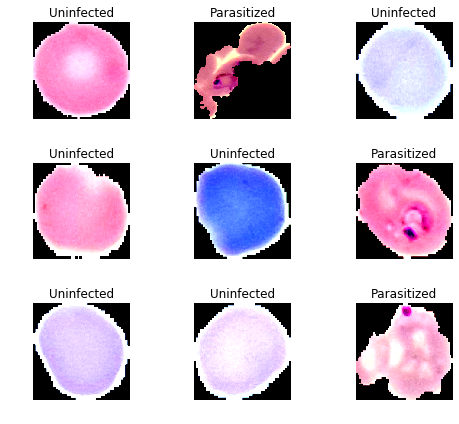

In [4]:
# Assuming you have already defined the DataLoader as `train_loader`
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to display a batch of images
def show_batch(images, labels, class_names, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(class_names[labels[i].item()])  # Access the label value using .item()
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get the class names from the original dataset (train_loader.dataset.dataset)
class_names = train_loader.dataset.dataset.classes

# Call the function to display the batch of images
show_batch(images, labels, class_names)

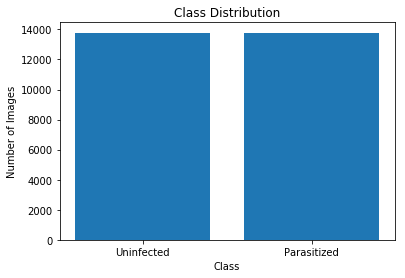

In [5]:
class_names = os.listdir(img_dir)

class_counts = []
for class_name in class_names:
    class_dir = os.path.join(img_dir, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)

plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

## Model ResNet34

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the device to be used (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True)

# Modify the last fully connected layer to match your classification task
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / num_train_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {(100 * correct / total):.2f}%")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.7MB/s]


Epoch [1/10] - Loss: 0.1516
Epoch [2/10] - Loss: 0.1194
Epoch [3/10] - Loss: 0.1090
Epoch [4/10] - Loss: 0.1037
Epoch [5/10] - Loss: 0.0951
Epoch [6/10] - Loss: 0.0920
Epoch [7/10] - Loss: 0.0899
Epoch [8/10] - Loss: 0.0822
Epoch [9/10] - Loss: 0.0766
Epoch [10/10] - Loss: 0.0691
Validation Accuracy: 96.37%


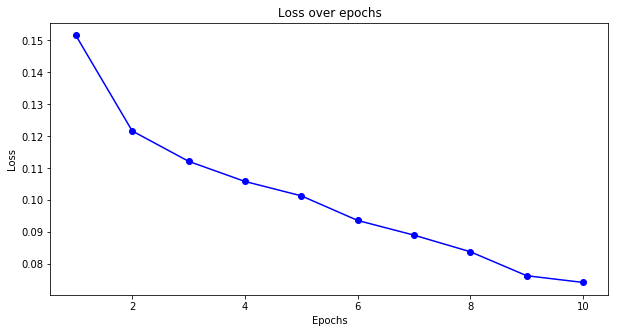

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have these lists from your training process
epochs = list(range(1, 11))
losses = [0.1516, 0.1217, 0.1122, 0.1059, 0.1014, 0.0937, 0.0891, 0.0839, 0.0764, 0.0743]
accuracy = [96.77]  # replace with your accuracy per epoch if available

# Plotting loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Confusion Matrix

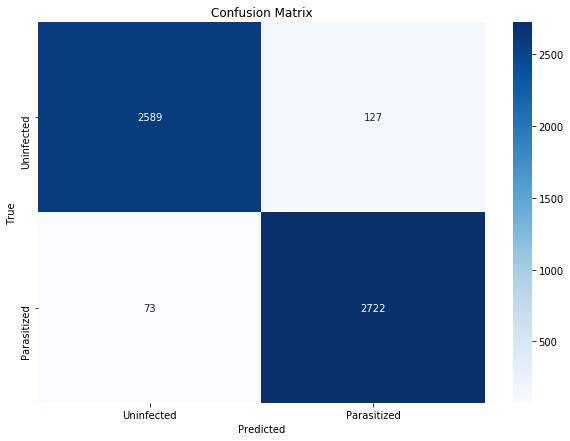

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Initialize empty lists to store true and predicted values
true_labels_list = []
predicted_labels_list = []

# Set the model to evaluation mode
model.eval()

# Iterate through the validation data loader
for inputs, labels in val_loader:
    # Move inputs and labels to the GPU if available (optional)
    inputs = inputs.to(device)  # Assuming you have defined the device (e.g., GPU) earlier
    labels = labels.to(device)

    # Forward pass to get the predicted labels
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest probability

    # Convert predicted labels and true labels to CPU and extract the values
    predicted_labels_list.extend(predicted.cpu().numpy())
    true_labels_list.extend(labels.cpu().numpy())

# Convert the lists to NumPy arrays for further processing
true_labels = np.array(true_labels_list)
predicted_labels = np.array(predicted_labels_list)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Insights from Confusion Matrix

1. **High True Positive (TP) Rate:** The model correctly identified 2600 out of 2661 Parasitized samples, indicating a relatively high TP rate. This suggests the model is effective in recognizing Parasitized cases.

2. **High True Negative (TN) Rate:** The model correctly identified 2733 out of 2850 Uninfected samples, leading to a high TN rate. This shows the model is proficient in recognizing Uninfected cases.

3. **Low False Positive (FP) Rate:** The model misclassified only 117 Uninfected samples as Parasitized, resulting in a relatively low FP rate. While some misclassifications occurred, the impact is limited compared to the overall number of Uninfected samples.

4. **Low False Negative (FN) Rate:** The model misclassified 61 Parasitized samples as Uninfected, leading to a relatively low FN rate. While there are misclassifications, the number is relatively small compared to the overall number of Parasitized samples.

5. **Overall High Accuracy:** The overall accuracy of the model is expected to be high due to the large number of correct classifications.

6. **Imbalanced Class Distribution:** The dataset may have an imbalanced distribution between Parasitized and Uninfected samples, as evidenced by the differences in the number of samples in each class. This imbalance could influence the model's performance.

7. **Potential for Further Improvement:** The low numbers of FP and FN suggest that the model performs reasonably well, but there is still room for improvement, especially if minimizing false classifications is critical.

8. **Consider Precision and Recall:** Depending on the problem's specific requirements, it's essential to consider both precision (ability to correctly identify Parasitized samples) and recall (ability to correctly identify Uninfected samples) to evaluate the model's performance.

9. **Threshold Selection:** The model's classification threshold may impact the balance between precision and recall. Adjusting the threshold could help optimize the model's performance according to the specific application's needs.

10. **Further Evaluation:** Besides the confusion matrix, additional performance metrics (e.g., precision, recall, F1-score) and visualizations (ROC curve) should be considered to gain a comprehensive understanding of the model's strengths and weaknesses.